# ECG Data Analysis

ECG values for waves and intervals in seconds & milliseconds: https://emedicine.medscape.com/article/2172196-overview?form=fpf

- RR interval: 0.6-1.2 seconds
- P wave: 80 milliseconds
- PR interval: 120-200 milliseconds
- PR segment: 50-120 milliseconds
- QRS complex: 80-100 milliseconds
- ST segment: 80-120 milliseconds
- T wave: 160 milliseconds
- QT interval: 420 milliseconds or less if heart rate is 60 beats per minute (bpm)

In [2]:
import wfdb # For reading in the data from the Physionet dataset
import numpy as np
# import neurokit2 as nk # Library for cleaning ECG signal and performing automated pre-processing
import matplotlib.pyplot as plt
from scipy.signal import buttord ,butter, filtfilt # Using butterworth filter as example
import pandas as pd
import ast
import os

%matplotlib inline

In [3]:
def read_record(df, sampling_rate, path: str, physical):
    if sampling_rate == 100:
        record = [wfdb.rdrecord(f'{path}/{f}', channel_names=['III', 'V3', 'V5'], physical=physical)
                  for f in df.filename_lr]
    else:
        record = [wfdb.rdrecord(f'{path}/{f}', channel_names=['III', 'V3', 'V5'], physical=physical)
                  for f in df.filename_hr]
    data = np.array([signal for signal in record])
    return data

In [4]:
physical=True
pretrain_path = '../data/pretrain'
Y = pd.read_csv(pretrain_path+'/ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
X = read_record(Y, 100, pretrain_path, physical)

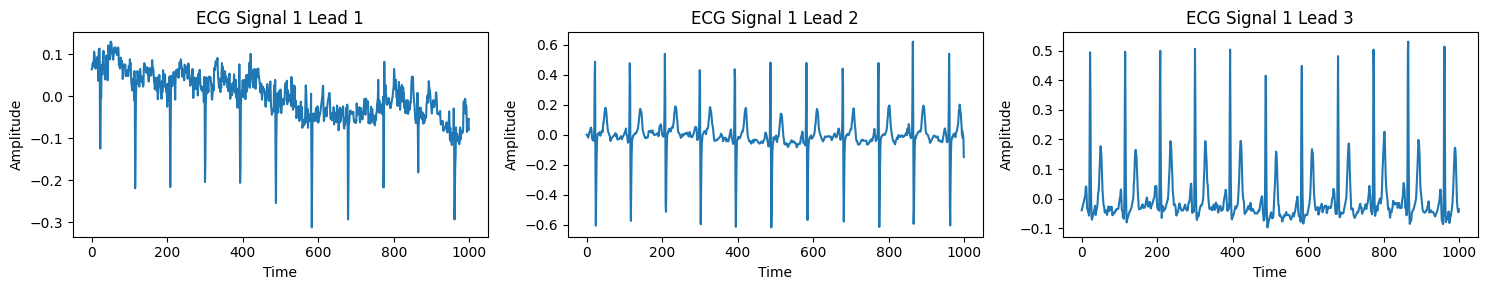

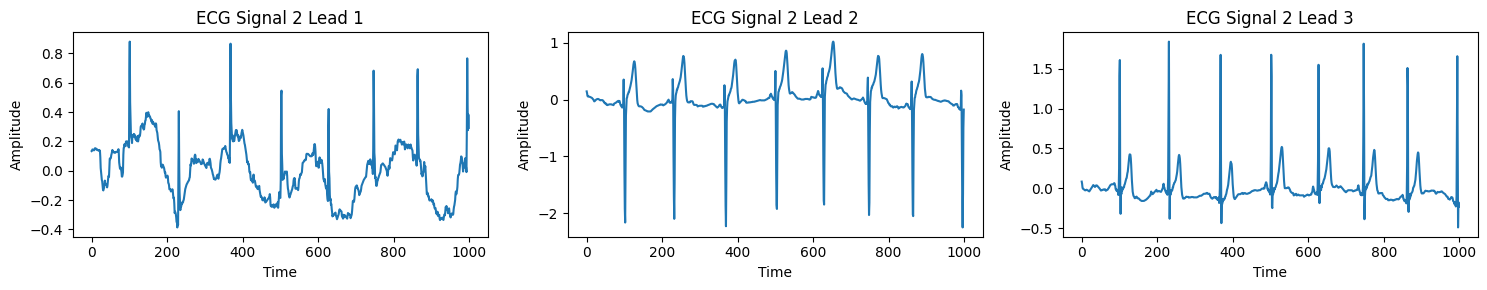

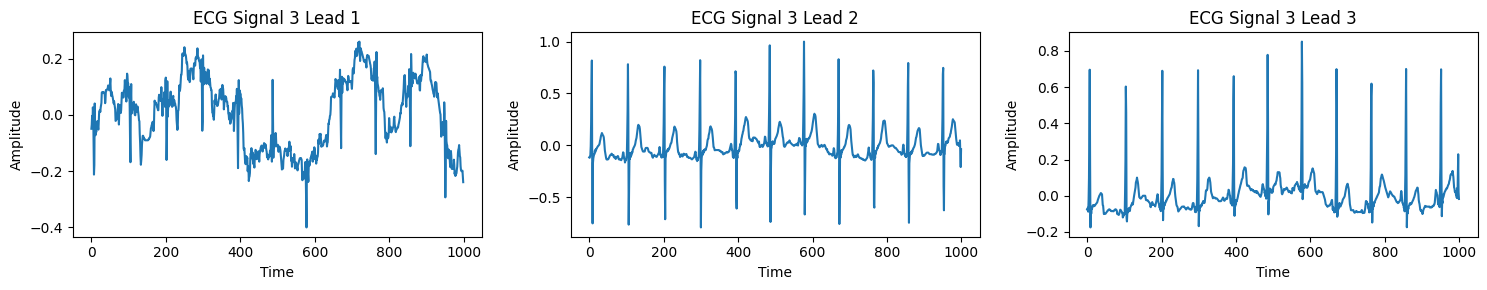

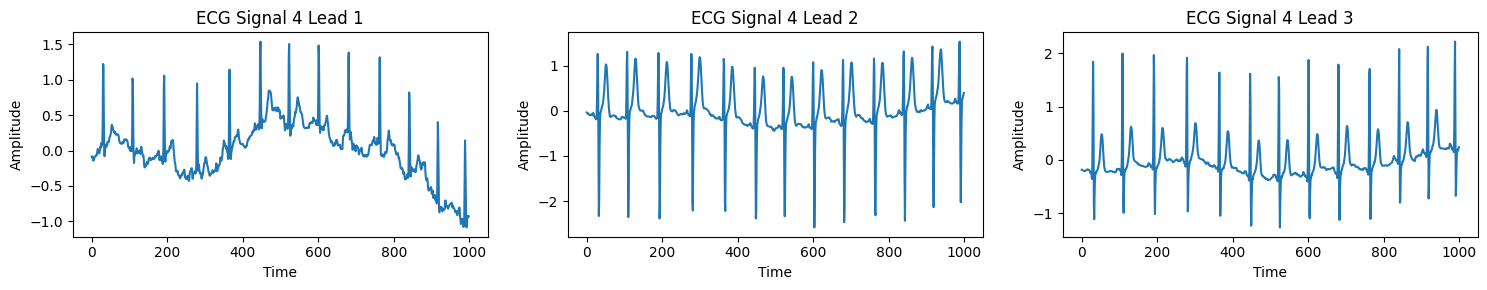

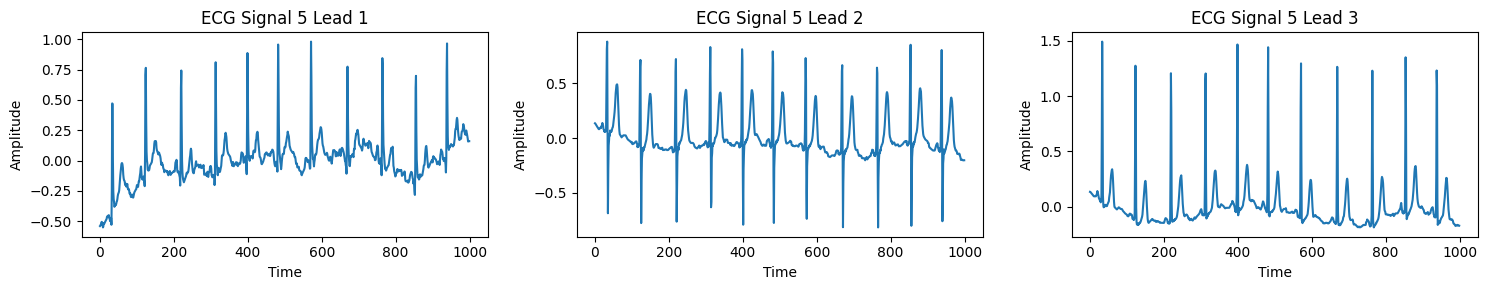

In [5]:
num_signals_to_plot = 5  # Number of signals to plot
num_leads = X[0].p_signal.shape[1]  # Number of leads in each signal

for i in range(num_signals_to_plot):
    signal = X[i].p_signal
    fig, axes = plt.subplots(1, num_leads, figsize=(15, 3))
    for j in range(num_leads):
        axes[j].plot(signal[:, j])
        axes[j].set_title(f'ECG Signal {i+1} Lead {j+1}')
        axes[j].set_xlabel('Time')
        axes[j].set_ylabel('Amplitude')
    plt.tight_layout()
    plt.show()


In [6]:
diagnostic_classes = {
    "NORM" : "Normal",
    "MI" : "Myocardial Infarction",
    "STTC" : "ST/T Changes",
    "CD" : "Conduction Disturbance",
    "HYP" : "Hypertrophy"
}

ptb_metadata = pd.read_csv(pretrain_path+'/ptbxl_database.csv')
ptb_metadata['diagnostic_class'] = ptb_metadata['scp_codes'].apply(lambda x: next((k for k in diagnostic_classes if k in x), 'OTHER'))
print(ptb_metadata['diagnostic_class'].value_counts())

diagnostic_class
NORM     9514
OTHER    6661
MI       5287
CD        313
HYP        24
Name: count, dtype: int64


In [13]:
normal_ratio = 0.7
abnormal_ratio = 0.3

normal_ecgs = ptb_metadata[ptb_metadata['diagnostic_class'] == "NORM"]
abnormal_ecgs = ptb_metadata[ptb_metadata['diagnostic_class'] != "NORM"]

# print(normal_ecgs.count())

# Sample based on desired proportions
n_total = 13000  # Total records for pretraining
n_normal = int(n_total * normal_ratio)
n_abnormal = n_total - n_normal

# Randomly sample from each category
normal_sample = normal_ecgs.sample(n=n_normal, random_state=42)
abnormal_sample = abnormal_ecgs.sample(n=n_abnormal, random_state=42)

# Merge biased dataset
biased_ptbxl = pd.concat([normal_sample, abnormal_sample]).reset_index(drop=True)

# Save or use for training
# biased_ptbxl.to_csv("biased_ptbxl.csv", index=False)
biased_ptbxl.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_class
0,8823,18596.0,59.0,0,NaN,NaN,0.0,0.0,CS100 3,1992-08-24 13:22:37,...,", V1",NaN,NaN,NaN,"2,V1",NaN,4,records100/08000/08823_lr,records500/08000/08823_hr,NORM
1,9934,18567.0,26.0,0,NaN,NaN,0.0,0.0,CS-12 E,1993-03-19 12:30:50,...,", V1",", V2,",V2,NaN,NaN,NaN,4,records100/09000/09934_lr,records500/09000/09934_hr,NORM
2,14452,5342.0,26.0,1,169.0,51.0,4.0,1.0,AT-6 6,1995-07-14 11:57:43,...,NaN,NaN,NaN,NaN,NaN,NaN,6,records100/14000/14452_lr,records500/14000/14452_hr,NORM
3,9984,15362.0,45.0,1,NaN,56.0,0.0,0.0,CS-12 E,1993-04-08 11:46:21,...,", V1",NaN,NaN,NaN,NaN,NaN,4,records100/09000/09984_lr,records500/09000/09984_hr,NORM
4,21149,16855.0,49.0,1,NaN,NaN,1.0,2.0,CS-12,2000-07-09 14:40:12,...,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21149_lr,records500/21000/21149_hr,NORM


In [19]:
import wfdb.processing


pretrain_path = "../data/pretrain"
selected_filenames = biased_ptbxl["filename_lr"].values
ecg_signals = []
segment_length = 640  # 5 seconds at 128 Hz
half_seg = segment_length // 2  # 320 samples

for filename in selected_filenames:
    file_path = os.path.join(pretrain_path, filename)
    if os.path.exists(f"{file_path}.dat"):
        record = wfdb.rdrecord(file_path, channel_names=['III', 'V3', 'V5'], physical=True)
        # Use the first channel for R-peak detection.
        channel = record.p_signal[:, 0]
        # Detect R-peaks using wfdb's gqrs detector.
        r_peaks = wfdb.processing.gqrs_detect(sig=channel, fs=record.fs)
        # Check if there's at least one valid R-peak that allows a 640-sample segment:
        valid_r_peaks = [r for r in r_peaks if r >= half_seg and r <= len(channel) - half_seg]
        if valid_r_peaks:
            ecg_signals.append(record)
        else:
            print(f"No valid R-peak found for {filename}. Skipping record.")

ecg_signals = np.array(ecg_signals, dtype=object)
np.save('biased_ptbxl_ecgs.npy', ecg_signals)

No valid R-peak found for records100/09000/09285_lr. Skipping record.
No valid R-peak found for records100/13000/13172_lr. Skipping record.
No valid R-peak found for records100/18000/18667_lr. Skipping record.
No valid R-peak found for records100/20000/20523_lr. Skipping record.
No valid R-peak found for records100/21000/21782_lr. Skipping record.
No valid R-peak found for records100/05000/05750_lr. Skipping record.
No valid R-peak found for records100/21000/21302_lr. Skipping record.
No valid R-peak found for records100/15000/15030_lr. Skipping record.
No valid R-peak found for records100/07000/07059_lr. Skipping record.
No valid R-peak found for records100/10000/10958_lr. Skipping record.
No valid R-peak found for records100/12000/12855_lr. Skipping record.
No valid R-peak found for records100/04000/04971_lr. Skipping record.
No valid R-peak found for records100/18000/18214_lr. Skipping record.
No valid R-peak found for records100/06000/06639_lr. Skipping record.
No valid R-peak foun